# Using Nilearn for statistical analysis of fMRI data in BIDS format

This tutorial is based on [this analysis](https://nilearn.github.io/stable/auto_examples/07_advanced/plot_bids_analysis.html)
 and [this analysis](https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_single_subject_single_run.html#sphx-glr-auto-examples-00-tutorials-plot-single-subject-single-run-py) presented on the Nilearn web-page.
 
## What is Nilearn?
Nilearn is one of the packages in the growing ["nipy" ecosystem](https://nipy.org/) of Python packages for neuroimaging analysis (see also [MNE](https://mne.tools/stable/index.html), [nistats](https://nistats.github.io/), [nipype](https://nipype.readthedocs.io/en/latest), [nibabel](https://nipy.org/nibabel/), [NiPreps](https://www.nipreps.org), and [dipy](http://dipy.org/)). Specifically, Nilearn provides tools for analysis techniques like functional connectivity, multivariate (machine-learning based) "decoding", but also more "basic" tools like image manipulation and visualization.

# BIDS dataset first and second level analysis


The tutorial contains step-by-step example of fitting a `GLM` to perform a first (single subject) and second level (group) analysis in a `BIDS` dataset and visualizing the results.

#### Brain Imaging Data Structure (BIDS)
`BIDS`is a particular convention for storing neuroimaging data, which makes it easier to reproduce and share analyses:

![img](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fsdata.2016.44/MediaObjects/41597_2016_Article_BFsdata201644_Fig1_HTML.jpg)

Details about the `BIDS` standard can be consulted at
[http://bids.neuroimaging.io](http://bids.neuroimaging.io/).



## In this tutorial, we will:

1. Download an fMRI `BIDS` dataset with two language conditions to contrast (reading sentences and letter strings).
2. Extract first level (single subject) model objects automatically from the `BIDS` dataset.
3. Investigate the model and plot it design matrix, contrasts and effects.
4. Fit a second level (group) model on the fitted first level models. Notice that
   in this case the preprocessed `BOLD` images were already normalized to the
   same `MNI` space.
5. Apply correction for multiple comparisons (FDR- and Bonferroni-corrections)
6. Run non-parametric permutation test to correct p-values
7. Plot the results in different ways to show some of the possibilities in Nilearn.

**Time to complete:** 30 min

In [3]:
# import some functionality

import os
import pip
os.system('python -m pip install numpy')
os.system('python -m pip install matplotlib')
os.system('python -m pip install scipy')
os.system('python -m pip install panda')
os.system('python -m pip install nilearn')

#import os.path as op
#import numpy as np
#from numpy.linalg import inv
#import nibabel as nib
import matplotlib.pyplot as plt
#from scipy.ndimage import gaussian_filter

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Fetch example BIDS dataset
We download a simplified `BIDS` dataset made available for illustrative
purposes. It contains only the necessary
information to run a statistical analysis using Nilearn. The raw data
subject folders only contain events.tsv files, while the
derivatives folder includes the preprocessed files preproc.nii and the
confounds.tsv files.


In [1]:
from nilearn.datasets import fetch_language_localizer_demo_dataset
data_dir, _ = fetch_language_localizer_demo_dataset()

print('Here is the location of the dataset on disk:', data_dir)


Dataset created in /home/ucloud/nilearn_data/fMRI-language-localizer-demo-dataset



Downloaded 748625920 of 749503182 bytes (99.9%,    0.0s remaining) ...done. (24 seconds, 0 min)
Extracting data from /home/ucloud/nilearn_data/fMRI-language-localizer-demo-dataset/fMRI-language-localizer-demo-dataset.zip...

Here is the location of the dataset on disk: /home/ucloud/nilearn_data/fMRI-language-localizer-demo-dataset


.. done.


### Investigating the BIDS structure
Let's make a function to see what this folder contains.

In [4]:
def list_files(startpath):
    """ Simple function to show directory tree. 
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python. """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
            
list_files(data_dir)

fMRI-language-localizer-demo-dataset/
    .bidsignore
    CHANGES
    README
    access_data.py
    dataset_description.json
    participants.tsv
    sub-09/
        func/
            sub-09_task-languagelocalizer_events.tsv
    sub-05/
        func/
            sub-05_task-languagelocalizer_events.tsv
    sub-07/
        func/
            sub-07_task-languagelocalizer_events.tsv
    sub-02/
        func/
            sub-02_task-languagelocalizer_events.tsv
    sub-10/
        func/
            sub-10_task-languagelocalizer_events.tsv
    sub-08/
        func/
            sub-08_task-languagelocalizer_events.tsv
    sub-03/
        func/
            sub-03_task-languagelocalizer_events.tsv
    derivatives/
        dataset_description.json
        sub-09/
            func/
                sub-09_task-languagelocalizer_desc-confounds_regressors.tsv
                sub-09_task-languagelocalizer_desc-preproc_bold.json
                sub-09_task-languagelocalizer_desc-preproc_bold.nii.gz
 

### What is in the BIDS folder?
This `BIDS` dataset folder contains different mandatory elements ([http://bids.neuroimaging.io](http://bids.neuroimaging.io/)). These include:
- A folder for each participant, e.g. `sub-01`. This contains a subfolder called `func` where the raw BOLD data is usually stored along with a `.tsv` file describing the events (experimental design) of the particular scan. In this dataset the raw data has been left out. Also the `anat`folder, which normally contains anatomical scans have been left out.
- A folder called `derivatives` which is used to store processed data. In this dataset, we will can find preprocessed data files `preproc_bold.nii` and the `confounds_regressors.tsv` files (which contains the motion parameters from the spatial realignment. 
- A number of `.json` files with meta-data.

NB. All the filenames contain a description of the particular experiment.

## Obtain automatically FirstLevelModel objects and fit arguments
The first-level models estimate beta-parameters for each voxel given our predictors (stimulus predictor, nuisance regressors, etc.). One model is estimated for each subject, so that we will have a first-level statistical map of the brain for each participant, with the values on each voxel corresponding to the effect of the predictors on the signal of that voxel. 

From the dataset directory we automatically obtain the FirstLevelModel objects
with their subject_id filled from the :term:`BIDS` dataset. Moreover, we obtain
for each model a dictionary with run_imgs, events and confounder regressors
since in this case a confounds.tsv file is available in the :term:`BIDS` dataset.
To get the first level models we only have to specify the dataset directory
and the task_label (`languagelocalizer`) as specified in the file names.



In [6]:
from nilearn.glm.first_level import first_level_from_bids
task_label = 'languagelocalizer'
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label,
        img_filters=[('desc', 'preproc')])

/opt/conda/lib/python3.10/site-packages/nilearn/interfaces/bids/query.py:46: UserWarning: 'StartTime' not found in file /home/ucloud/nilearn_data/fMRI-language-localizer-demo-dataset/derivatives/sub-01/func/sub-01_task-languagelocalizer_desc-preproc_bold.json.
  warn(f"'{field}' not found in file {json_files[0]}.")
/opt/conda/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:1017: UserWarning: 'slice_time_ref' not provided and cannot be inferred from metadata.It will be assumed that the slice timing reference is 0.0 percent of the repetition time. If it is not the case it will need to be set manually in the generated list of models.
  warn("'slice_time_ref' not provided "


[FirstLevelModel(subject_label='09', t_r=1.5),
 FirstLevelModel(subject_label='05', t_r=1.5),
 FirstLevelModel(subject_label='08', t_r=1.5),
 FirstLevelModel(subject_label='03', t_r=1.5),
 FirstLevelModel(subject_label='01', t_r=1.5),
 FirstLevelModel(subject_label='07', t_r=1.5),
 FirstLevelModel(subject_label='10', t_r=1.5),
 FirstLevelModel(subject_label='02', t_r=1.5),
 FirstLevelModel(subject_label='04', t_r=1.5),
 FirstLevelModel(subject_label='06', t_r=1.5)]

### What just happened?
A lot happened in a few lines of code. That is great, but also confusing.
![confused_emoji.jpeg](images/confused_emoji.jpeg)

What did the function actually do? Let's look into the `first_level_from_bids` function.

In [6]:
#What does the `first_level_from_bid` function take as arguments?
import inspect
import pandas as pd
#Get the argument from the function
args=inspect.getfullargspec(first_level_from_bids)

#Make a dataframe to display arguments (skip the first two ('dataset_path' and 'task_label') that have no defaults
df = pd.DataFrame(args.defaults,args.args[2:])

#You don't have to use the print() function for Pandas.
df

#Same info can also be obtained by writing "first_level_from_bids?"

,0
space_label,None
img_filters,None
t_r,None
slice_time_ref,0.0
hrf_model,glover
drift_model,cosine
high_pass,0.01
drift_order,1
fir_delays,[0]
min_onset,-24


Here, we can see that the function uses information about `t_r` (TR), `HRF_model` (hemodynamic response function),``drift_model`` and `high_pass` (both used for high-pass filtering), `noise_model`(it uses "ar1" for modelling auto correlation). In other words, this function seems to implement all the elements, we have been going through in previous tutorials.

<b>Nice stuff!</b>

## Quick sanity check on fit arguments
Additional checks or information extraction from pre-processed data can
be made here.



As, we have seen from the folder inspection, we only have one run_img per subject.


In [7]:
import os
#Get the file names for subj01 functional data
func01=([os.path.basename(run) for run in models_run_imgs[0]])
print(func01)



['sub-01_task-languagelocalizer_desc-preproc_bold.nii.gz']


Let's load this file and inspect the data.

In [8]:
from nilearn import image

#Get the full path
func01_path=([os.path.abspath(run) for run in models_run_imgs[0]])
#Load the image and inspect data size
func_img = image.load_img(func01_path)
print("Shape of functional MRI image: %s" % (func_img.shape,))

Shape of functional MRI image: (45, 53, 43, 229)


As we see, the data contains 229 volumes with a 45 x 53 x43 voxel resolution.

In [9]:
print(models[0])

FirstLevelModel(subject_label='01', t_r=1.5)


Here, we see that the model is a `FirstLevelModel` object ([See here for details](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html)). This means that it incorporates all the same default values for setting up and estimating GLM-fMRI models as in the `first_level_from_bids`, unless else is mentioned. 

We also see the additional information that data were obtained with a TR of 1.5 seconds.


Let's inspect what we find in the `models_confounds` variable.

In [10]:
print(models_confounds[0][0].columns)

Index(['RotX', 'RotY', 'RotZ', 'X', 'Y', 'Z'], dtype='object')


The only confounds stored are regressors obtained from motion correction. As
we can verify from the column headers of the confounds table corresponding
to the only run_img present. These correspond to the rotations and translations, we covered in the <tt>05_fMRI_preprocessing_spatial.ipynb</tt> tutorial.

Let's see what is in the `models_events`variable:

In [11]:
print(type(models_events[0]))

print(models_events[0])

<class 'list'>
[      onset  duration trial_type
0     3.516     6.806   language
1    17.707     7.004     string
2    32.011     6.805   language
3    46.306     7.206     string
4    60.604     6.804   language
5    74.908     6.804     string
6    89.208     6.808   language
7   103.508     6.806     string
8   117.804     6.806   language
9   132.108     6.809     string
10  146.407     6.805   language
11  160.702     6.807     string
12  175.007     6.804   language
13  189.304     6.805     string
14  203.608     6.802   language
15  217.910     6.806     string
16  232.206     6.809   language
17  246.504     6.802     string
18  260.807     6.800   language
19  275.109     6.806     string
20  289.406     6.806   language
21  303.703     6.803     string
22  318.007     6.807   language
23  332.305     6.810     string]


The function has loaded the `...events.tsv` file, which contains information about the experiment and has put it in a list variable.

Here, we can see that the experiment used a <b>block design</b> where each block lasted *6.8 seconds*.

During the experiment, the subject read blocks of *sentences* and
*consonant strings*. 

So these are our only two conditions in events.

We can see check how many blocks were in each condition:

In [12]:
print(models_events[0][0]['trial_type'].value_counts())

language    12
string      12
Name: trial_type, dtype: int64


12 blocks of each!

## First level (single subject) model estimation
Now, that we have seen that if we have a correctly structured BIDS dataset, the `first_level_from_bids` function gathers everything we need for analysis, we can get going with the analysis.

### Analysing one participant

We will start by analysing the data from the first participant and generating a report of the process and the results.

If we have a [`FirstLevelModel`](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) class object as we have created above, we can use the variable.fit() function to pair the `FirstLevelModel`object with the additionally needed information (e.g. functional images, events and a matrix of confounding variables), assemble the model and estimate it.

In [13]:
# Get data and model info for 1st participant
model1=models[0]
imgs1=models_run_imgs[0]
events1=models_events[0]
confounds1=models_confounds[0]

#Fit the model
model1.fit(imgs1,events1,confounds1)


FirstLevelModel(subject_label='01', t_r=1.5)

### Plotting the design matrix
We will then use the `plot_design_matrix`function to give the model a sanity check. 

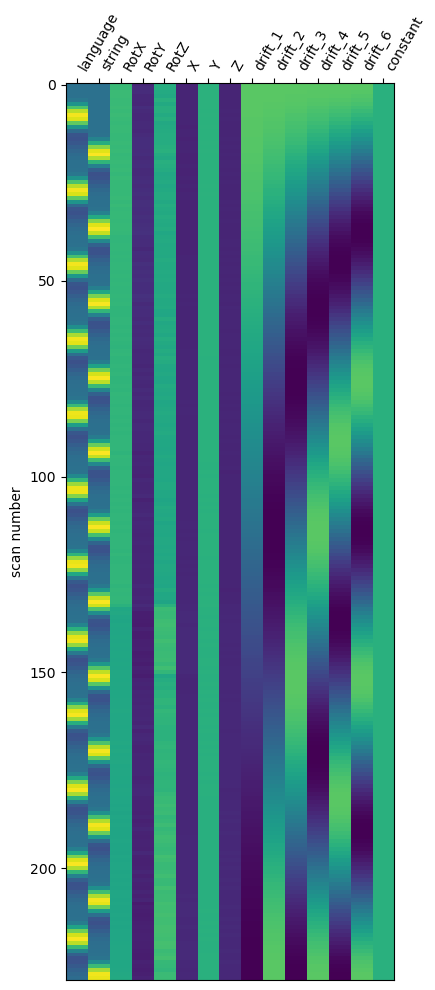

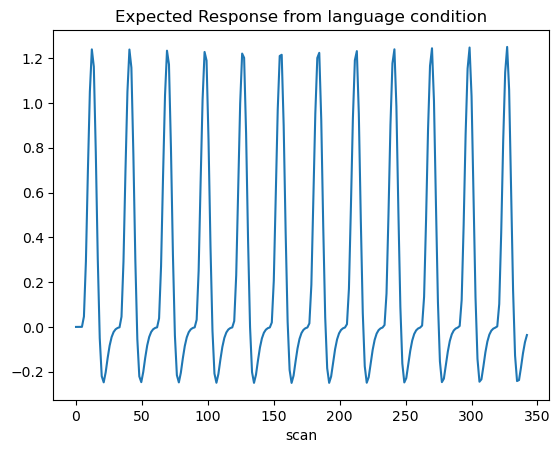

In [14]:

from nilearn.plotting import plot_design_matrix

# View the design matrix
design_matrix = model1.design_matrices_[0]

#Plot the design matrix
plot_design_matrix(design_matrix)
plt.show()

# Also plot time series of expected (HRF-convolved) response 
plt.plot(design_matrix['language'])
plt.xlabel('scan')
plt.title('Expected Response from language condition')
plt.show()

We see that the design matrix contains 2 columns for the conditions + 6 for the motion parameters + 6 cosine functions for high-pass filtering + one constant/intercept. The 6 motion parameters we gave the model as input explicitly, while the 6 cosine functions were added automatically because the *drift_model* parameter of the model was set to "cosine". This drift model is the default in nilearn, but it is possible to change the parameter. 

When plotting the expected response function, we see that it looks like the hemodynamic response function. This is because the *hrf* parameter of the model was set to "glover", so the signal is automatically HRF-convolved using the glover HRF function. 


### Defining contrasts
Alright. Now we have fitted the model and have the expected response across the entire run. But what we are actually interested in, is testing whether there is a *difference* in the predicted response between conditions! This is tested statistically using `contrasts`. 

These can be defined using using vectors or the names of of the conditions, specified in the events dataframe. Sum, subtraction and scalar multiplication are allowed. Let's look at some example contrasts with the two conditions in our experiment: 

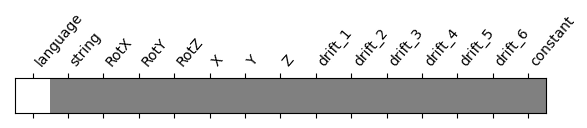

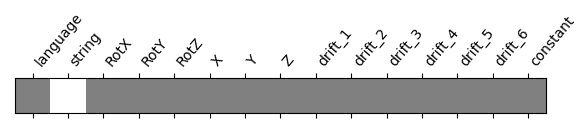

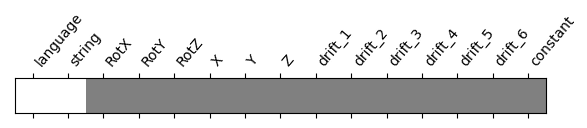

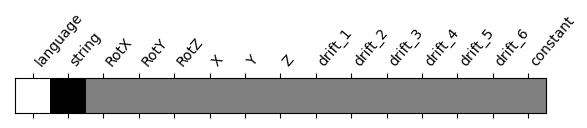

In [15]:
from nilearn.plotting import plot_contrast_matrix

#Define contrasts
contrasts=['language','string','language+string','language-string']

# Plot them to see what they look like
for contrast in contrasts:
    plot_contrast_matrix(contrast, design_matrix=design_matrix)

In the plot above, the first contrast indicate that we want to test whether trials of the *language* condition has any significant effect on the BOLD signal compared to the baseline signal. 

The second contrast, tests whether trials of the *string* condition has any significant effect on the BOLD signal compared to the baseline signal. 

The third contrast, tests whether **both** trials of the *string* **and** the *language* condition has any effect on teh BOLD signal compared to the baseline signal. 

The last contrast, test whether the *language* condition has a different effect on the BOLD signal compared to the *string* condition (i.e., when we subtract the effects that also occur in the *string* condition). 

Importantly, the contrast is tested for each voxel. That is, the result will be a 3D image with the beta-parameter of the difference for all voxels (zmap), and we can then evaluate which of the voxels survive the significance threshold and plot them - and these are the "areas" that showed a significant effect in BOLD response given our contrast. 

Now, let's do all of this, to make it a bit more clear! 

### Setting the significance threshold
To display the results, we will set a statistical threshold. Conventionally p<0.001, uncorrected for multiple comparisons has been used. When we plot our results, all values above this threshold will be set to 0, while all values below the threshold will be colored according to the size of the effect. That is, we display only the voxels that are significant below our defined threshold. 

It often gives a good picture of what is at play in the data, but should be interpreted with caution, due to the fact that it is uncorrected (uncorrected for multiple comparisons - we'll come back to this later)

In [16]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

### Compute contrasts and plot the results
Now, we will compute each of the four contrasts and plot the results. We will do so using the mean of the functional data as background.

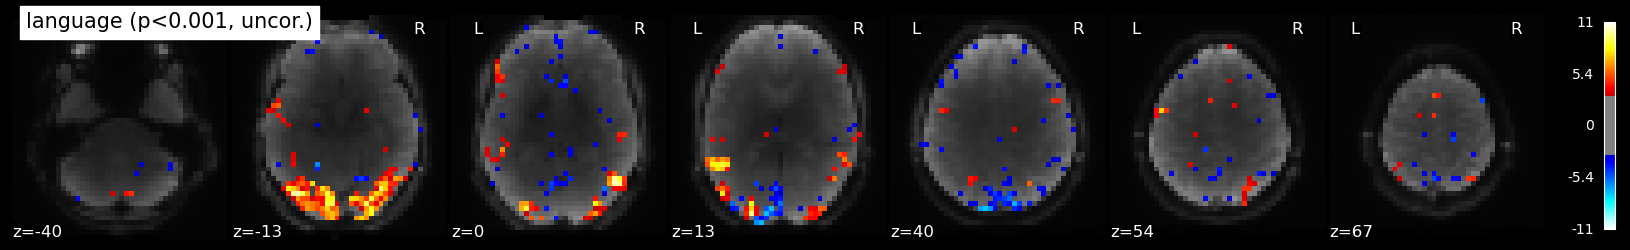

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1 -26.0 -93.5   9.0  10.713609               1913
1           2  59.5 -66.5  -4.5  10.323233              23419
2          2a  50.5 -71.0   0.0   9.907819                   
3          2b  41.5 -75.5 -18.0   9.205176                   
4          2c  28.0 -84.5 -18.0   8.962386                   
5           3 -39.5 -80.0 -13.5  10.038853              16038
6          3a -30.5 -93.5   0.0   8.788013                   
7          3b -12.5 -80.0 -13.5   8.699447                   
8          3c  -8.0 -89.0 -13.5   8.667378                   
9           4 -53.0 -80.0  18.0   9.019140               8292
10         4a -53.0 -53.0  13.5   8.539359                   
11         4b -66.5 -53.0  22.5   6.992901                   
12         4c -53.0 -39.5   0.0   6.061066                   
13          5 -57.5   1.0 -18.0   5.979050               2460
14         5a -62.0 -21.5  -4.5   5.780083                   
15      

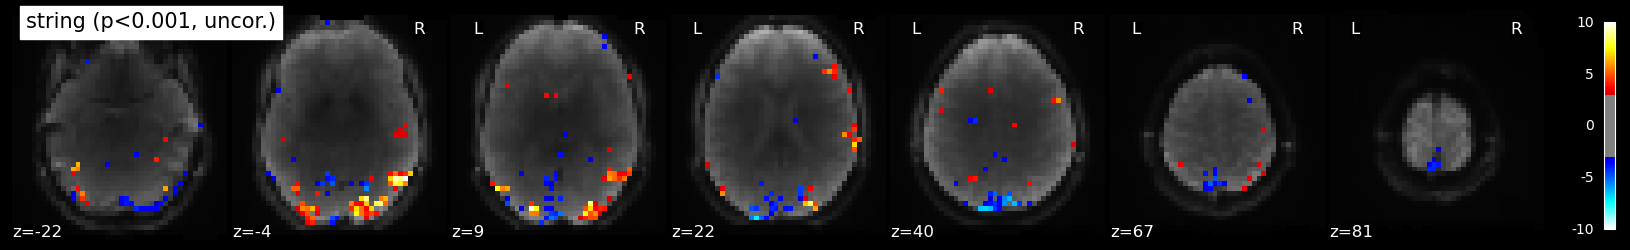

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1  59.5 -66.5  -4.5  10.020973               6561
1          1a  50.5 -66.5  13.5   6.755233                   
2          1b  64.0 -57.5   9.0   4.947216                   
3           2  37.0 -75.5 -13.5   9.841084              17587
4          2a  23.5 -84.5 -18.0   9.412331                   
5          2b  23.5 -84.5  -4.5   8.872917                   
6          2c  37.0 -89.0  -4.5   8.857896                   
7           3 -39.5 -80.0 -13.5   9.597943              13851
8          3a  -8.0 -84.5 -13.5   9.139444                   
9          3b -30.5 -93.5   0.0   7.647824                   
10         3c -21.5 -93.5 -18.0   6.614261                   
11          4 -53.0 -80.0  18.0   8.802447               3098
12         4a -53.0 -71.0   0.0   4.670248                   
13          5  68.5 -35.0  22.5   6.934049               2004
14         5a  73.0 -26.0  18.0   6.901880                   


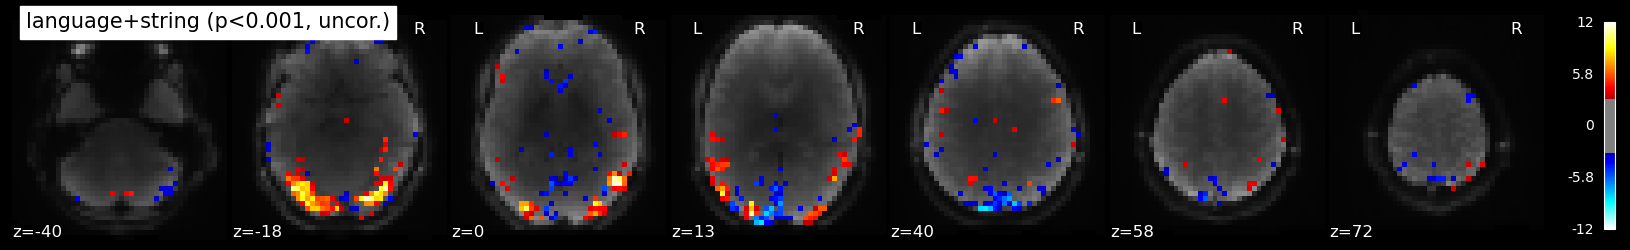

   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1  59.5 -66.5  -4.5  11.675437              27337
1          1a  50.5 -71.0   0.0  11.242294                   
2          1b  23.5 -84.5 -18.0  11.052155                   
3          1c  37.0 -75.5 -13.5  10.806124                   
4           2 -26.0 -93.5   9.0  11.521835              19956
5          2a -39.5 -80.0 -13.5  11.193576                   
6          2b  -8.0 -89.0 -13.5  10.030732                   
7          2c -30.5 -93.5   0.0   9.617355                   
8           3 -53.0 -80.0  18.0  10.198792               6014
9          3a -66.5 -53.0  22.5   6.017957                   
10         3b -57.5 -57.5  13.5   5.724533                   
11         3c -48.5 -53.0  13.5   5.293652                   
12          4  28.0 -80.0  49.5   6.524991               2004
13         4a  23.5 -89.0  54.0   5.563438                   


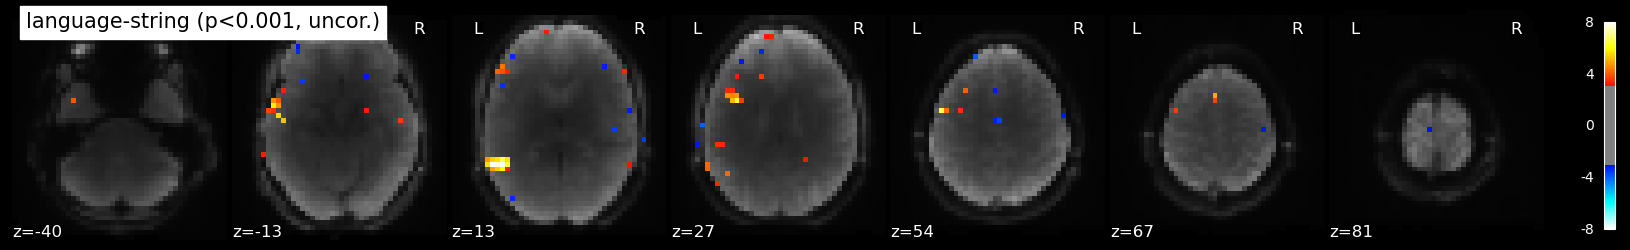

  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1 -62.0 -53.0  13.5   7.999482               5467
1         1a -53.0 -53.0  13.5   7.928554                   
2         1b -53.0 -39.5   0.0   6.542459                   
3         1c -66.5 -44.0   4.5   6.287263                   
4          2 -57.5   1.0 -18.0   5.911692               2369
5         2a -57.5  -8.0 -13.5   5.496280                   
6         2b -57.5  10.0 -18.0   5.450501                   
7          3 -57.5  32.5  18.0   5.593998               2460
8         3a -48.5  37.0   9.0   4.907037                   
9         3b -57.5  37.0   0.0   4.636844                   


In [17]:
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img

# Make a mean image for display purposes
mean_img_ = mean_img(imgs1)

for contrast in contrasts:
    z_map = model1.compute_contrast(contrast, output_type='z_score') #here we compute the contrast effect! 

    #Now we plot the resulting zmap using the uncorrected p-value threshold 
    titlex=''.join([contrast, ' ', '(p<0.001, uncor.)'])
    plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc,
              display_mode='z',  black_bg=True,
              title=titlex)
    plt.show()
    
    # Make a table of cluster coordinates.
    table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
    print(table)

### Make a report of the results

We can also use the [`make_glm_report`](https://nistats.github.io/modules/generated/nistats.reporting.make_glm_report.html) function to make a report in one go. This report is generated as a HTML document, which can only be viewed in a notebook.

This also includes a table of cluster coordinates.

In [18]:
from nilearn.reporting import make_glm_report
#Generate a report
report = make_glm_report(model1,
                         contrasts=contrasts,
                         threshold=p001_unc,
                         bg_img=mean_img_,
                         )
#Display report in HTML format
report

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,glover
noise_model,ar1
scaling_axis,0
signal_scaling,0
slice_time_ref,0.0
smoothing_fwhm,None
standardize,False


### Analysing all single participants in one go and plotting them

Now, we will make a loop which fits all the models and plots the results. We will focus on the *language-string* contrast.



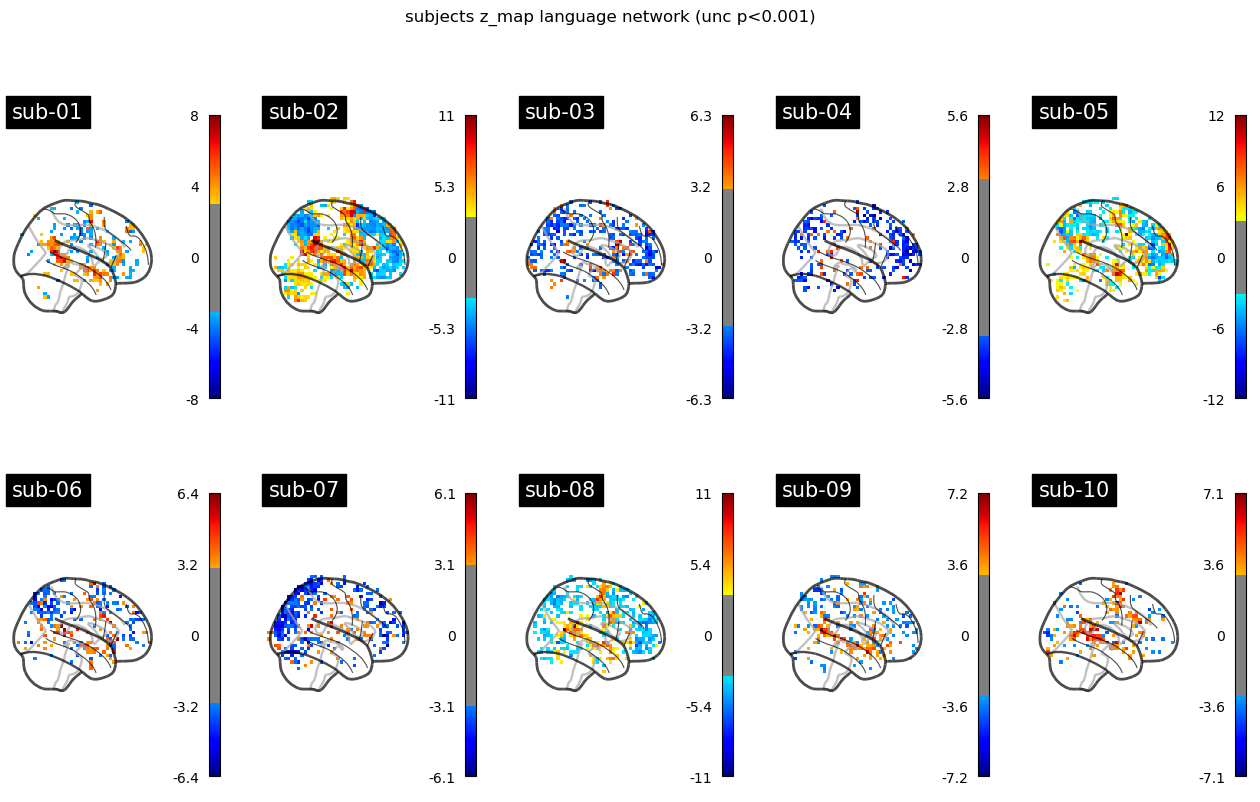

In [19]:
from nilearn import plotting
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 9))
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)
zmap_list = []
for m_idx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM, recall that the model variable is a FirstLevelModel object
    model.fit(imgs, events, confounds)
    # compute the contrast of interest and make a map of z-values
    zmap = model.compute_contrast('language-string')
    zmap_list.append(zmap)
    #Plot each thresholded analysis
    plotting.plot_glass_brain(zmap, cmap='jet',colorbar=True, threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(m_idx / 5), int(m_idx % 5)],
                              plot_abs=False, display_mode='x')
fig.suptitle('subjects z_map language network (unc p<0.001)')
plotting.show()

Note that the single subject results look very different, although one can also see patterns in most participants that look similar.

Great. Now we have a statistical map of z-values indicating the effect of our contrast on each voxel for each participant. 

To investigate the degree of overlap in the data, we will perform a 2nd level analysis, where the contrast estimates for each individual participant will enter as data in a new statistical test.

## Second level (group) model estimation


In experiments with repeated measurements across participants, data are usually (in non-fMRI contexts) analyzed in a single multilevel GLM by "concatenating" the data. In fMRI, we usually don't take this approach due to the computational burden. Instead we use the summary statistics approach, which analyzes each partcipant separately and subsequently aggregates the data in a second, participant-level GLM. 

![summary_statistics_approach.png](images/summary_statistics_approach.png)


Basically, this amounts to doing the same thing as when we fit first-level models, but this time, the results from our participant-level analyses ($c\hat{\beta}^{*}$) across different subjects will become our target ($y^{\dagger}$). We use the "dagger" ($^{\dagger}$) superscript to denote that the mathematical terms belong to the group-level model.

To reiterate, the results from our participant-level analyses ($c\hat{\beta}^{*}$), become our dependent variable in our group-level analysis ($y^{\dagger}$):

\begin{align}
y^{\dagger} = c\hat{\beta}^{*}
\end{align}

Again, the group-level represents a GLM with a particular design matrix ($\mathbf{X}^{\dagger}$) and parameters ($\beta^{\dagger}$):

\begin{align}
y^{\dagger} = \mathbf{X}^{\dagger}\beta^{\dagger} + \epsilon^{\dagger}
\end{align}

And the group-level parameters can be estimated with OLS:

\begin{align}
\hat{\beta}^{\dagger} = (\mathbf{X}^{\dagger\ T} \mathbf{X}^{\dagger})^{-1}\mathbf{X}^{\dagger}y^{\dagger}
\end{align}

The parameter estimation procedure (i.e., estimating $\hat{\beta}^{\dagger}$) is the same as for individual participants, and using only one summary statistic data-point (e.g. beta image or contrast image) per participant, has the advantage of effectively making sure that we treat participants as random effects. 


### Making a 2nd level model in Nilearn
We just have to provide the list of fitted `FirstLevelModel` objects
to the `SecondLevelModel` object for estimation. We can do this because
all subjects share a similar design matrix (same variables reflected in
column names). It is also possible to give the first-level zmaps (instead of the models) as input to the second-level model (in which case it will only be able to model the group effect of the specific first-level contrast that the zmap was estimated for). 

In [40]:
from nilearn.glm.second_level import SecondLevelModel
#We will simply add the models estimated above to the second level
second_level_input = models
#second_level_input = zmap_list

Let's fit the model. 

Importantly, the `second_level_model.fit()` takes a design_matrix as input in addition to the first-level models. The design matrix for second-level models has one row per subject (rather than per timepoint as for first-level models). That is, in the second-level design matrix we can include predictors pertaining to each subject and estimate the contrast between them. This is for instance useful if we want to model the effect of *age*, *gender* or patient vs. control groups. The design matrix also needs an intercept (constant) as before. However, for the current analysis we are only interested in the effects specified in the first-level contrasts across the *entire* group - i.e., we have no additional predictors at the second-level. This is termed an *intercept model*, as we only have the intercept in our design matrix. For this reason, we do not need to input a design matrix to the second-level model below, as it will assume that when no design matrix is given, it has to compute an intercept-only model (i.e., simply estimate the effect of the first-level contrast across the entire group). 

Note that we also apply a spatial smoothing kernel of 8mm.

In [41]:
#The design matrix contains only an intercept
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=['intercept'],
)

#Adding the smoothing parameter and fitting the model 
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)
#second_level_model = second_level_model.fit(second_level_input, design_matrix=design_matrix) # When we are running an intercept model it doesn't matter whether we specify the design matrix or not 

Computing contrasts at the second level is as simple as at the first level.
Since we are not providing confounders we are performing a one-sample test
at the second level with the images determined by the specified first level
contrast.

*(Again, if we had inputted the zmaps from the first-level contrasts to the second-level model we would not have to specify the first-level contrast here, because that would be the only one possible in that case. But since the first-level **model** objects contain all four contrasts, we now have to specify which one we want to compute the second-level contrast for).* 

In [38]:
zmap_g = second_level_model.compute_contrast(
    first_level_contrast='language-string')



Just for demonstration. *IF* we were interested in modeling the effect of for instance *gender* on the language-string contrast effect, we could have fitted the model and estimated the contrast as following: 

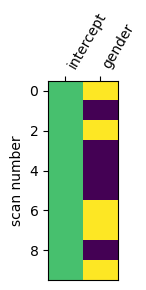

In [23]:
import numpy as np 

#Assuming 10 subjects we'll define a design matrix with intercept and gender (0=male, 1=female)
intercept = np.ones(10)
gender = [1,0,1,0,0,0,1,1,0,1] #the order of subjects in the design matrix should of course correspond to the order of the first-level images inputted to the second level model
design_matrix = pd.DataFrame({"intercept":intercept, "gender":gender})

plotting.plot_design_matrix(design_matrix)

#Fit second level model 
second_level_model_gender = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model_gender = second_level_model_gender.fit(second_level_input, design_matrix=design_matrix)
zmap_gender = second_level_model_gender.compute_contrast(
    first_level_contrast='language-string',
    second_level_contrast='gender') 

#Note that now we pass the second-level deisgn matrix (including gender variable) to the model 
#And then we compute the contrast between gender conditions. 
#This amounts to assessing whether the effect of the language-string condition differs between genders 

<div class='alert alert-warning'>
    <b>Summary on first-level vs. second-level parameters</b> : 

The design matrix for 
- First-level models -> indicate features pertaining to each *timepoint/measurement* across time within one subject (e.g., condition, rt, stimulus, etc.)
- Second level models -> indicate features pertaining to each *subject* (e.g., age, gender, experimental group, etc.)

The contrasts indicate 
- In first-level models -> differences between *trials* within each subject (e.g., between conditions) 
- In second-level models -> differences between *subjects* on the first-level effects (e.g., between genders, experimental groups, etc.)
    
</div>



Now, let's look at the results from our group model. Below we plot all the voxels that survived the (uncorrected) significance threshold. We will plot the results on a glass brain. 

The group level contrast reveals a slightly left lateralized, primarily temporal
reading network.


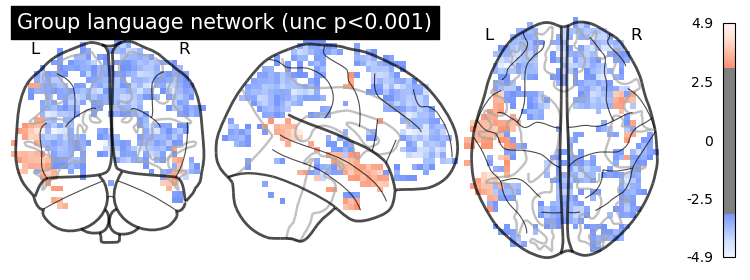

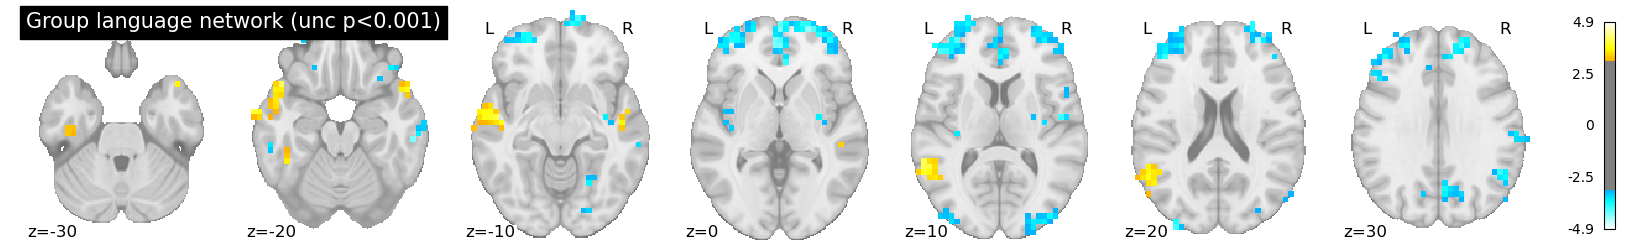

In [24]:
plotting.plot_glass_brain(zmap_g, cmap='blue_red',colorbar=True, threshold=p001_unc,
                          title='Group language network (unc p<0.001)',
                          plot_abs=False)
plt.show()

plot_stat_map(zmap_g, cmap='cold_hot',threshold=p001_unc, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group language network (unc p<0.001)')
plt.show()

This is equivalent to thresholding a z-statistic image with a false positive rate < .001.

### Correcting for multiple comparisons

Nilearn allows you to make different corrections for multiple comparisons.
Here, we will try correcting for the false discovery rate (FDR) and the familiy-wise error rate (FWER)

The FDR=.05 threshold is 2.81
The p<.05 Bonferroni-corrected threshold is 4.74


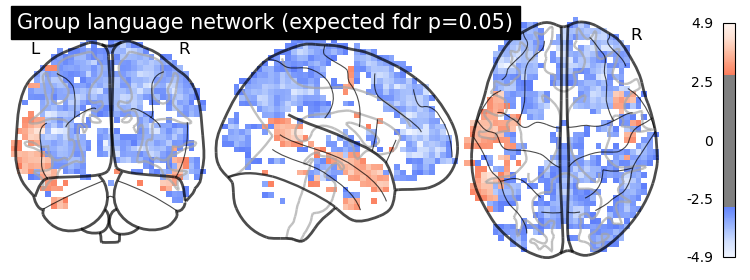

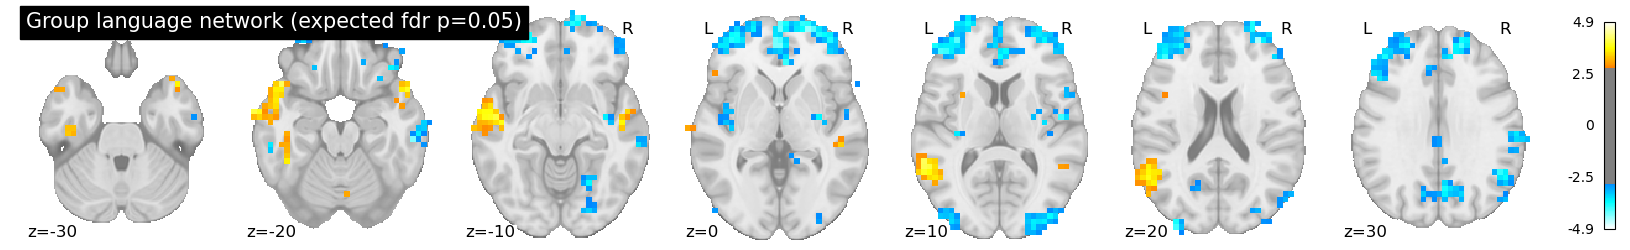

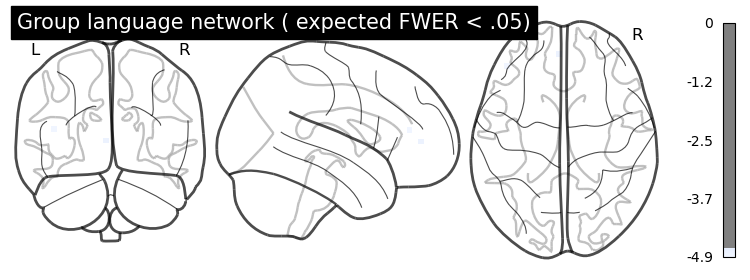

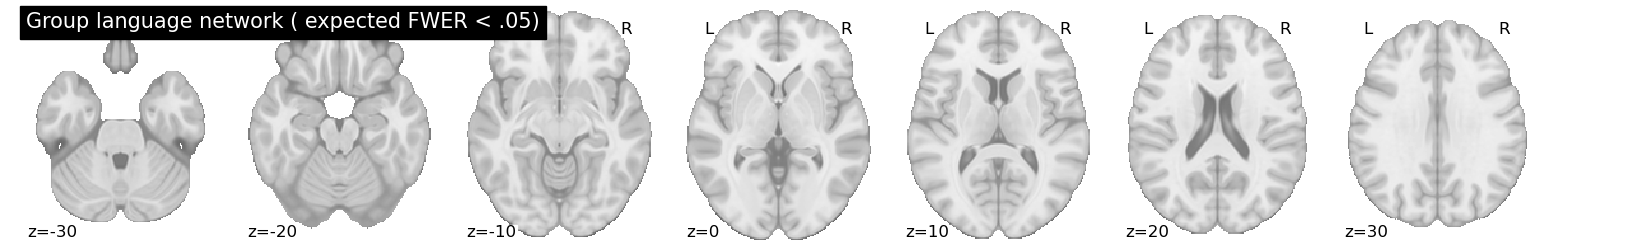

In [25]:
from nilearn.glm import threshold_stats_img

#FDR-correction with alpha=0.05
thresholded_map2, threshold2 = threshold_stats_img(
    zmap_g, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)

#Bonferonni-correction wtih alpha=0.05 
thresholded_map3, threshold3 = threshold_stats_img(
    zmap_g, alpha=.05, height_control='bonferroni')
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3)


plotting.plot_glass_brain(thresholded_map2, cmap='blue_red',colorbar=True, threshold=threshold2,
                          title='Group language network (expected fdr p=0.05)',
                          plot_abs=False)
plt.show()

plot_stat_map(thresholded_map2, cmap='cold_hot', threshold=threshold2,cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group language network (expected fdr p=0.05)')
plt.show()

plotting.plot_glass_brain(thresholded_map3, cmap='blue_red',colorbar=True, threshold=threshold3,
                          title='Group language network ( expected FWER < .05)',
                          plot_abs=False)
plt.show()

plot_stat_map(thresholded_map3, cmap='cold_hot', threshold=threshold3,cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group language network ( expected FWER < .05)')
plt.show()

As can be seen, the fdr correction may be too lenient, and the FWE correction may be too stringent.

## Non-parametric permutation methods for calculating corrected p-values

Based on [this](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py) example.

Permutation tests are a class of non-parametric methods. They were pioneered by Fisher (1935) and Pitman (1937). Fisher demonstrated that the null hypothesis could be tested simply by observing, after permuting observations, how often the difference between means would exceed the difference found without permutation, and that for such test, no normality would be required.


![permutation_stats.jpg](images/permutation_stats.jpg)

If we are comparing two samples (e.g. `treatment` and `control`), we can calculate the effect, we get when shuffling the category labels.

![Permutation_test_example_animation.gif](images/Permutation_test_example_animation.gif)
Source:[Wikipedia](https://en.wikipedia.org/wiki/Permutation_test)

The percentage of values we get that are bigger than our original value, represents the probability that our value comes from the null-distribution.

The one-sided p-value of the test is calculated as the proportion of sampled permutations where the difference in means was greater than ${\displaystyle T_{\text{obs}}}$. 
The two-sided p-value of the test is calculated as the proportion of sampled permutations where the absolute difference was greater than 
${\displaystyle |T_{\text{obs}}|}$.

When conducting a one-sample group analysis with fMRI-data, we are testing ${\displaystyle H_{0}:T=0}$, i.e.  if the effect of any given voxel is larger than zero. We can obtain a null-distribution by estimating the effect N times, while randomly flipping the sign on each datapoint.

In [26]:
import numpy as np
from nilearn.image import get_data, math_img

#Get an image of p-values 
p_val = second_level_model.compute_contrast(first_level_contrast = 'language-string', output_type='p_value')
# Get the number of voxels in the image
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Making an image with significant values, correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    '-np.log10(np.minimum(1, img * {}))'.format(str(n_voxels)),
    img=p_val,
)

#Check image shape
print(neg_log_pval.shape)

(45, 53, 43)


<string>:1: RuntimeWarning: divide by zero encountered in log10


We now perform the permutations.

In [27]:
print(second_level_input) 

[FirstLevelModel(subject_label='01', t_r=1.5), FirstLevelModel(subject_label='02', t_r=1.5), FirstLevelModel(subject_label='03', t_r=1.5), FirstLevelModel(subject_label='04', t_r=1.5), FirstLevelModel(subject_label='05', t_r=1.5), FirstLevelModel(subject_label='06', t_r=1.5), FirstLevelModel(subject_label='07', t_r=1.5), FirstLevelModel(subject_label='08', t_r=1.5), FirstLevelModel(subject_label='09', t_r=1.5), FirstLevelModel(subject_label='10', t_r=1.5)]


In [28]:
#from nilearn.glm.second_level import non_parametric_inference
from second_level import non_parametric_inference_linesEdit #Import function from local script ("second_level.py") - I had to edit a bug in there in order to use this function with first-level model objects as input to second_level_input argument

# n_perm=1000 for the sake of time. Ideally, this should be 10,000, but the upper limit on permutations is 2 to the power of N.
n_perm=1000

#The design matrix contains only an intercept
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=['intercept'],
)

second_level_input = models
out_dict = non_parametric_inference_linesEdit(
    second_level_input,
    design_matrix=design_matrix,
    first_level_contrast='language-string',
    model_intercept=True,
    n_perm=n_perm,  
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=1,
)

Now let's plot the permutation results and compare with the bonferroni corrected effect. 

Note that effects are now negative log of the p-value, so we will have to take that into consideration when plotting.

/opt/conda/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


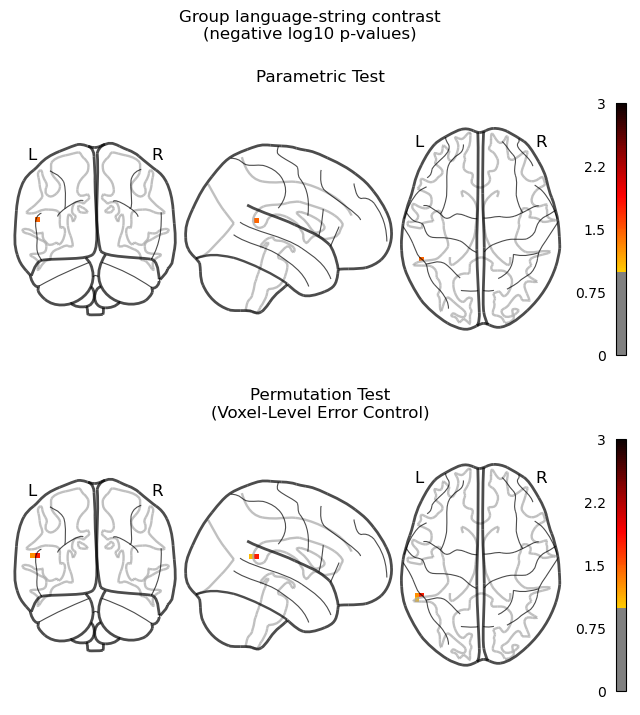

In [29]:
# Prepare thresholds for plotting

threshold_log = round(-np.log10(1 / 20))  # p < 0.05 
vmax = round(-np.log10(1 / n_perm)) # minimal p-value possible with the number of permuations

cut_coords = [0]

#Prepare images to plot
IMAGES = [
    neg_log_pval,
    out_dict
]
TITLES = [
    'Parametric Test',
    'Permutation Test\n(Voxel-Level Error Control)',
]

#Make loop with plots
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=1)
img_counter = 0
i_row=0
for j_row in range(2):
        ax = axes[j_row]     
        plotting.plot_glass_brain(
            IMAGES[img_counter],
            colorbar=True,
            vmax=vmax,
            plot_abs=False,
            cut_coords=cut_coords,
            threshold=threshold_log,
            figure=fig,
            axes=ax,
        )

        
        ax.set_title(TITLES[img_counter])
        img_counter += 1


fig.suptitle('Group language-string contrast\n(negative log10 p-values)')
plt.show()

As you can see, the permutation test is slightly more sensitive. 

A big advantage is that permutation tests are also more intuitive than many of the complex methods for multiple comparisons correction on the market.

### Inspect clusters on brain Atlas
The `atlasreader`package provide nice functions to automatically apply a brain atlas on our results to get information about which brain areas show effects in our analysis, their MNI coordinates, peak values, cluster size (in mm) etc. This information is typically used to report results. 

The create_output() function will create a table with cluster information and assoicated brain structure, and figures of each cluster. These are stored in the specified *out_dir* directory. Let's see how it works. Note, the *cluster_extent* parameter defines how many voxels are needed for it to be considered a cluster. 

In [30]:
os.system("pip install atlasreader")
from atlasreader import create_output

output_dir = "glm_results/"

# Step 3: Create output 
create_output(
    filename = out_dict,
    atlas='default',
    #voxel_thresh=1.96,
    voxel_thresh=threshold_log,
    direction='both',
    cluster_extent=5,
    glass_plot_kws = {'black_bg':True,'vmax':20,'colorbar':True, 'cmap': 'jet'},
    stat_plot_kws = {'black_bg':True,'cmap': 'jet','title':False},
    outdir=output_dir
    )

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



/opt/conda/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


Alright, if we look in the `glm_results` folder we see that there are actually no tables or cluster figures, only a file called *atlasreader.png*. What happened??? We see in the permutation test that there are at least some voxels surviving the threshold, so why don't we get any cluster information?? 

This is because we set our cluster_extent to 5 voxels as minimum, and apparently we have no clusters in our permutation results that consist of more than 5 voxels. 

Now, just to understand what would have happened if we actually had some clusters, we will try run the function on the fdr-thresholded image (which we saw had a lot of significant voxels!) Remember, the thresholded image was called *thresholded_map2* and the corresponding threshold value was called *threshold2*. 

In [31]:
output_dir = "glm_results/"

# Step 3: Create output 
create_output(
    filename = thresholded_map2,
    atlas='default',
    #voxel_thresh=1.96,
    voxel_thresh=threshold2,
    direction='both',
    cluster_extent=5,
    glass_plot_kws = {'black_bg':True,'vmax':20,'colorbar':True, 'cmap': 'jet'},
    stat_plot_kws = {'black_bg':True,'cmap': 'jet','title':False},
    outdir=output_dir
    )

Alright, let's check what's in the output directory: 

In [32]:
os.listdir(output_dir)

['atlasreader_peaks.csv',
 'atlasreader_cluster26.png',
 'atlasreader_cluster17.png',
 'atlasreader_cluster03.png',
 'atlasreader_cluster01.png',
 'atlasreader_cluster13.png',
 'atlasreader_cluster08.png',
 'atlasreader_cluster24.png',
 'atlasreader_cluster14.png',
 'atlasreader_cluster02.png',
 'atlasreader_cluster16.png',
 'atlasreader_cluster05.png',
 'atlasreader.png',
 'atlasreader_cluster10.png',
 'atlasreader_cluster18.png',
 'atlasreader_cluster15.png',
 'atlasreader_cluster04.png',
 'atlasreader_cluster09.png',
 'atlasreader_cluster06.png',
 'atlasreader_cluster27.png',
 'atlasreader_cluster12.png',
 'atlasreader_cluster07.png',
 'atlasreader_cluster21.png',
 'atlasreader_cluster11.png',
 'atlasreader_cluster25.png',
 'atlasreader_cluster23.png',
 'atlasreader_cluster22.png',
 'atlasreader_clusters.csv',
 'atlasreader_cluster20.png',
 'atlasreader_cluster19.png']

Okay. So now we have a lot of clusters! We can see that we have a *atlasreader_cluster.csv* and an *atlasreader_peaks.csv* file, which both contain information about the clusters. We also have a figure for each of the clusters detected. Let's inspect what's in the .csv files: 

In [33]:
peak_info_emo_baseline = pd.read_csv(os.path.join(output_dir, 'atlasreader_peaks.csv'))
display(peak_info_emo_baseline.head(5))

cluster_info_emo_baseline = pd.read_csv(os.path.join(output_dir, 'atlasreader_clusters.csv'))
display(cluster_info_emo_baseline.head(5))

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,50.5,-48.5,45.0,-4.54710,60324.80,Parietal_Inf_R,Right-Cerebral-White-Matter,53.0% Right_Angular_Gyrus; 12.0% Right_Suprama...
1,2,-3.5,50.5,4.5,-4.84022,47931.80,Cingulate_Ant_L,ctx-lh-superiorfrontal,85.0% Left_Paracingulate_Gyrus; 7.0% Left_Fron...
2,3,-44.0,41.5,13.5,-4.94853,40550.60,Frontal_Inf_Tri_L,ctx-lh-rostralmiddlefrontal,72.0% Left_Frontal_Pole; 9.0% Left_Middle_Fron...
3,4,-48.5,19.0,-18.0,4.12388,10206.00,Temporal_Pole_Sup_L,ctx-lh-superiortemporal,70.0% Left_Temporal_Pole
4,5,-53.0,-57.5,54.0,-3.96345,9294.75,no_label,Unknown,6.0% Left_Lateral_Occipital_Cortex_superior_di...


,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1,50.5,-48.5,45.0,-3.20304,60324.80,19.34% Precuneus_R; 13.60% no_label; 12.39% Pr...,48.04% Unknown; 11.03% Right-Cerebral-White-Ma...,19.64% Right_Precuneous_Cortex; 13.75% Left_Pr...
1,2,-3.5,50.5,4.5,-3.33574,47931.80,26.81% Frontal_Sup_2_R; 25.67% no_label; 19.01...,55.70% Unknown; 11.22% ctx-rh-superiorfrontal;...,47.34% Right_Frontal_Pole; 15.78% Right_Superi...
2,3,-44.0,41.5,13.5,-3.28871,40550.60,36.63% Frontal_Mid_2_L; 31.91% no_label; 26.07...,56.63% Unknown; 22.70% ctx-lh-rostralmiddlefro...,61.57% Left_Frontal_Pole; 15.96% Left_Middle_F...
3,4,-48.5,19.0,-18.0,3.27050,10206.00,48.21% Temporal_Mid_L; 17.86% Temporal_Pole_Su...,44.64% Unknown; 25.89% ctx-lh-superiortemporal...,25.89% Left_Temporal_Pole; 20.54% Left_Superio...
4,5,-53.0,-57.5,54.0,-3.18214,9294.75,50.98% no_label; 42.16% Parietal_Inf_L; 6.86% ...,56.86% Unknown; 16.67% ctx-lh-inferiorparietal...,26.47% Left_Angular_Gyrus; 21.57% Left_Suprama...


Cool! We can now see what brain structure our clusters are part of according to different atlases! 

Let's look at some of the cluster figures: 

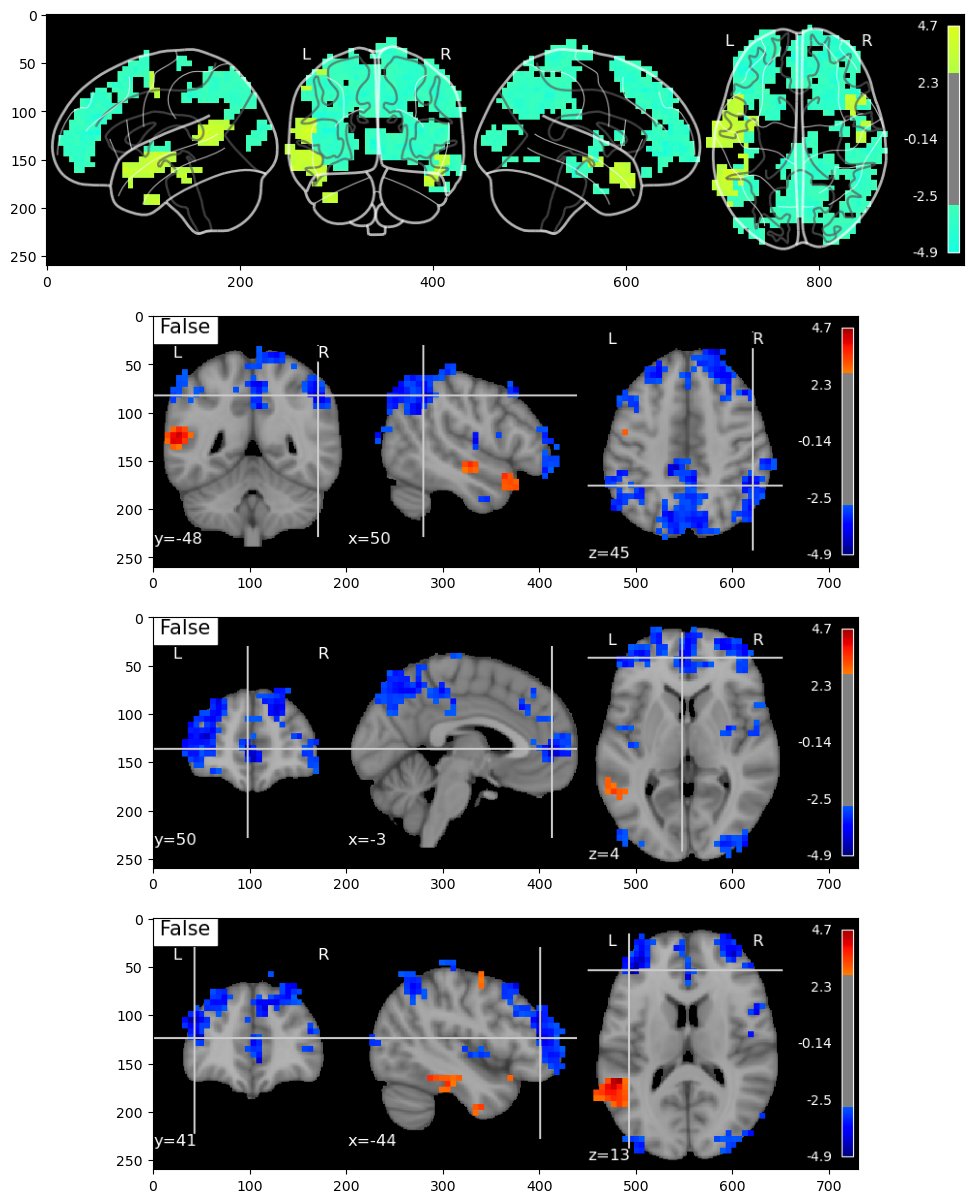

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 40,15

# read images
img_A = mpimg.imread(os.path.join(output_dir, 'atlasreader.png'))
img_B = mpimg.imread(os.path.join(output_dir, 'atlasreader_cluster01.png'))
img_C = mpimg.imread(os.path.join(output_dir, 'atlasreader_cluster02.png'))
img_D = mpimg.imread(os.path.join(output_dir, 'atlasreader_cluster03.png'))

# display images
fig, ax = plt.subplots(4)
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[2].imshow(img_C)
ax[3].imshow(img_D)

Great job! That's it. You now know how to run all steps of fMRI anlaysis!! 